In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, roc_curve

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Aviation Project/database.csv")
data.info()

<ipython-input-5-9968505dfd41>:1: DtypeWarning: Columns (9,12,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Aviation Project/database.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174104 entries, 0 to 174103
Data columns (total 66 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Record ID             174104 non-null  int64  
 1   Incident Year         174104 non-null  int64  
 2   Incident Month        174104 non-null  int64  
 3   Incident Day          174104 non-null  int64  
 4   Operator ID           174104 non-null  object 
 5   Operator              174104 non-null  object 
 6   Aircraft              174104 non-null  object 
 7   Aircraft Type         133074 non-null  object 
 8   Aircraft Make         131051 non-null  object 
 9   Aircraft Model        122439 non-null  object 
 10  Aircraft Mass         127320 non-null  float64
 11  Engine Make           123434 non-null  float64
 12  Engine Model          121988 non-null  object 
 13  Engines               127342 non-null  float64
 14  Engine Type           127282 non-null  object 
 15  

In [ ]:
print(data.head())

   Record ID  Incident Year  Incident Month  Incident Day Operator ID  \
0     127128           1990               1             1         DAL   
1     129779           1990               1             1         HAL   
2     129780           1990               1             2         UNK   
3       2258           1990               1             3         MIL   
4       2257           1990               1             3         MIL   

          Operator   Aircraft Aircraft Type Aircraft Make Aircraft Model  ...  \
0  DELTA AIR LINES  B-757-200             A           148             26  ...   
1     HAWAIIAN AIR       DC-9             A           583             90  ...   
2          UNKNOWN    UNKNOWN           NaN           NaN            NaN  ...   
3         MILITARY      A-10A             A           345            NaN  ...   
4         MILITARY       F-16             A           561            NaN  ...   

   Fuselage Strike  Fuselage Damage Landing Gear Strike  Landing Gear Dama

In [ ]:
data.rename(columns={"Engine1 Position":"Engine1_Position", "Engine2 Position":"Engine2_Position", "Engine3 Position":"Engine3_Position", "Engine4 Position":"Engine4_Position"}, inplace=True)
target = 'C'
target_2 = "CHANGE CODE"
print (data.columns)
data.query('Engine1_Position != @target', inplace=True)
data.query('Engine3_Position != @target_2', inplace=True)

Index(['Record ID', 'Incident Year', 'Incident Month', 'Incident Day',
       'Operator ID', 'Operator', 'Aircraft', 'Aircraft Type', 'Aircraft Make',
       'Aircraft Model', 'Aircraft Mass', 'Engine Make', 'Engine Model',
       'Engines', 'Engine Type', 'Engine1_Position', 'Engine2_Position',
       'Engine3_Position', 'Engine4_Position', 'Airport ID', 'Airport',
       'State', 'FAA Region', 'Warning Issued', 'Flight Phase', 'Visibility',
       'Precipitation', 'Height', 'Speed', 'Distance', 'Species ID',
       'Species Name', 'Species Quantity', 'Flight Impact', 'Fatalities',
       'Injuries', 'Aircraft Damage', 'Radome Strike', 'Radome Damage',
       'Windshield Strike', 'Windshield Damage', 'Nose Strike', 'Nose Damage',
       'Engine1 Strike', 'Engine1 Damage', 'Engine2 Strike', 'Engine2 Damage',
       'Engine3 Strike', 'Engine3 Damage', 'Engine4 Strike', 'Engine4 Damage',
       'Engine Ingested', 'Propeller Strike', 'Propeller Damage',
       'Wing or Rotor Strike', 'Win

<ipython-input-8-862cabdd348c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap = "inferno", annot=True, fmt=".2f")


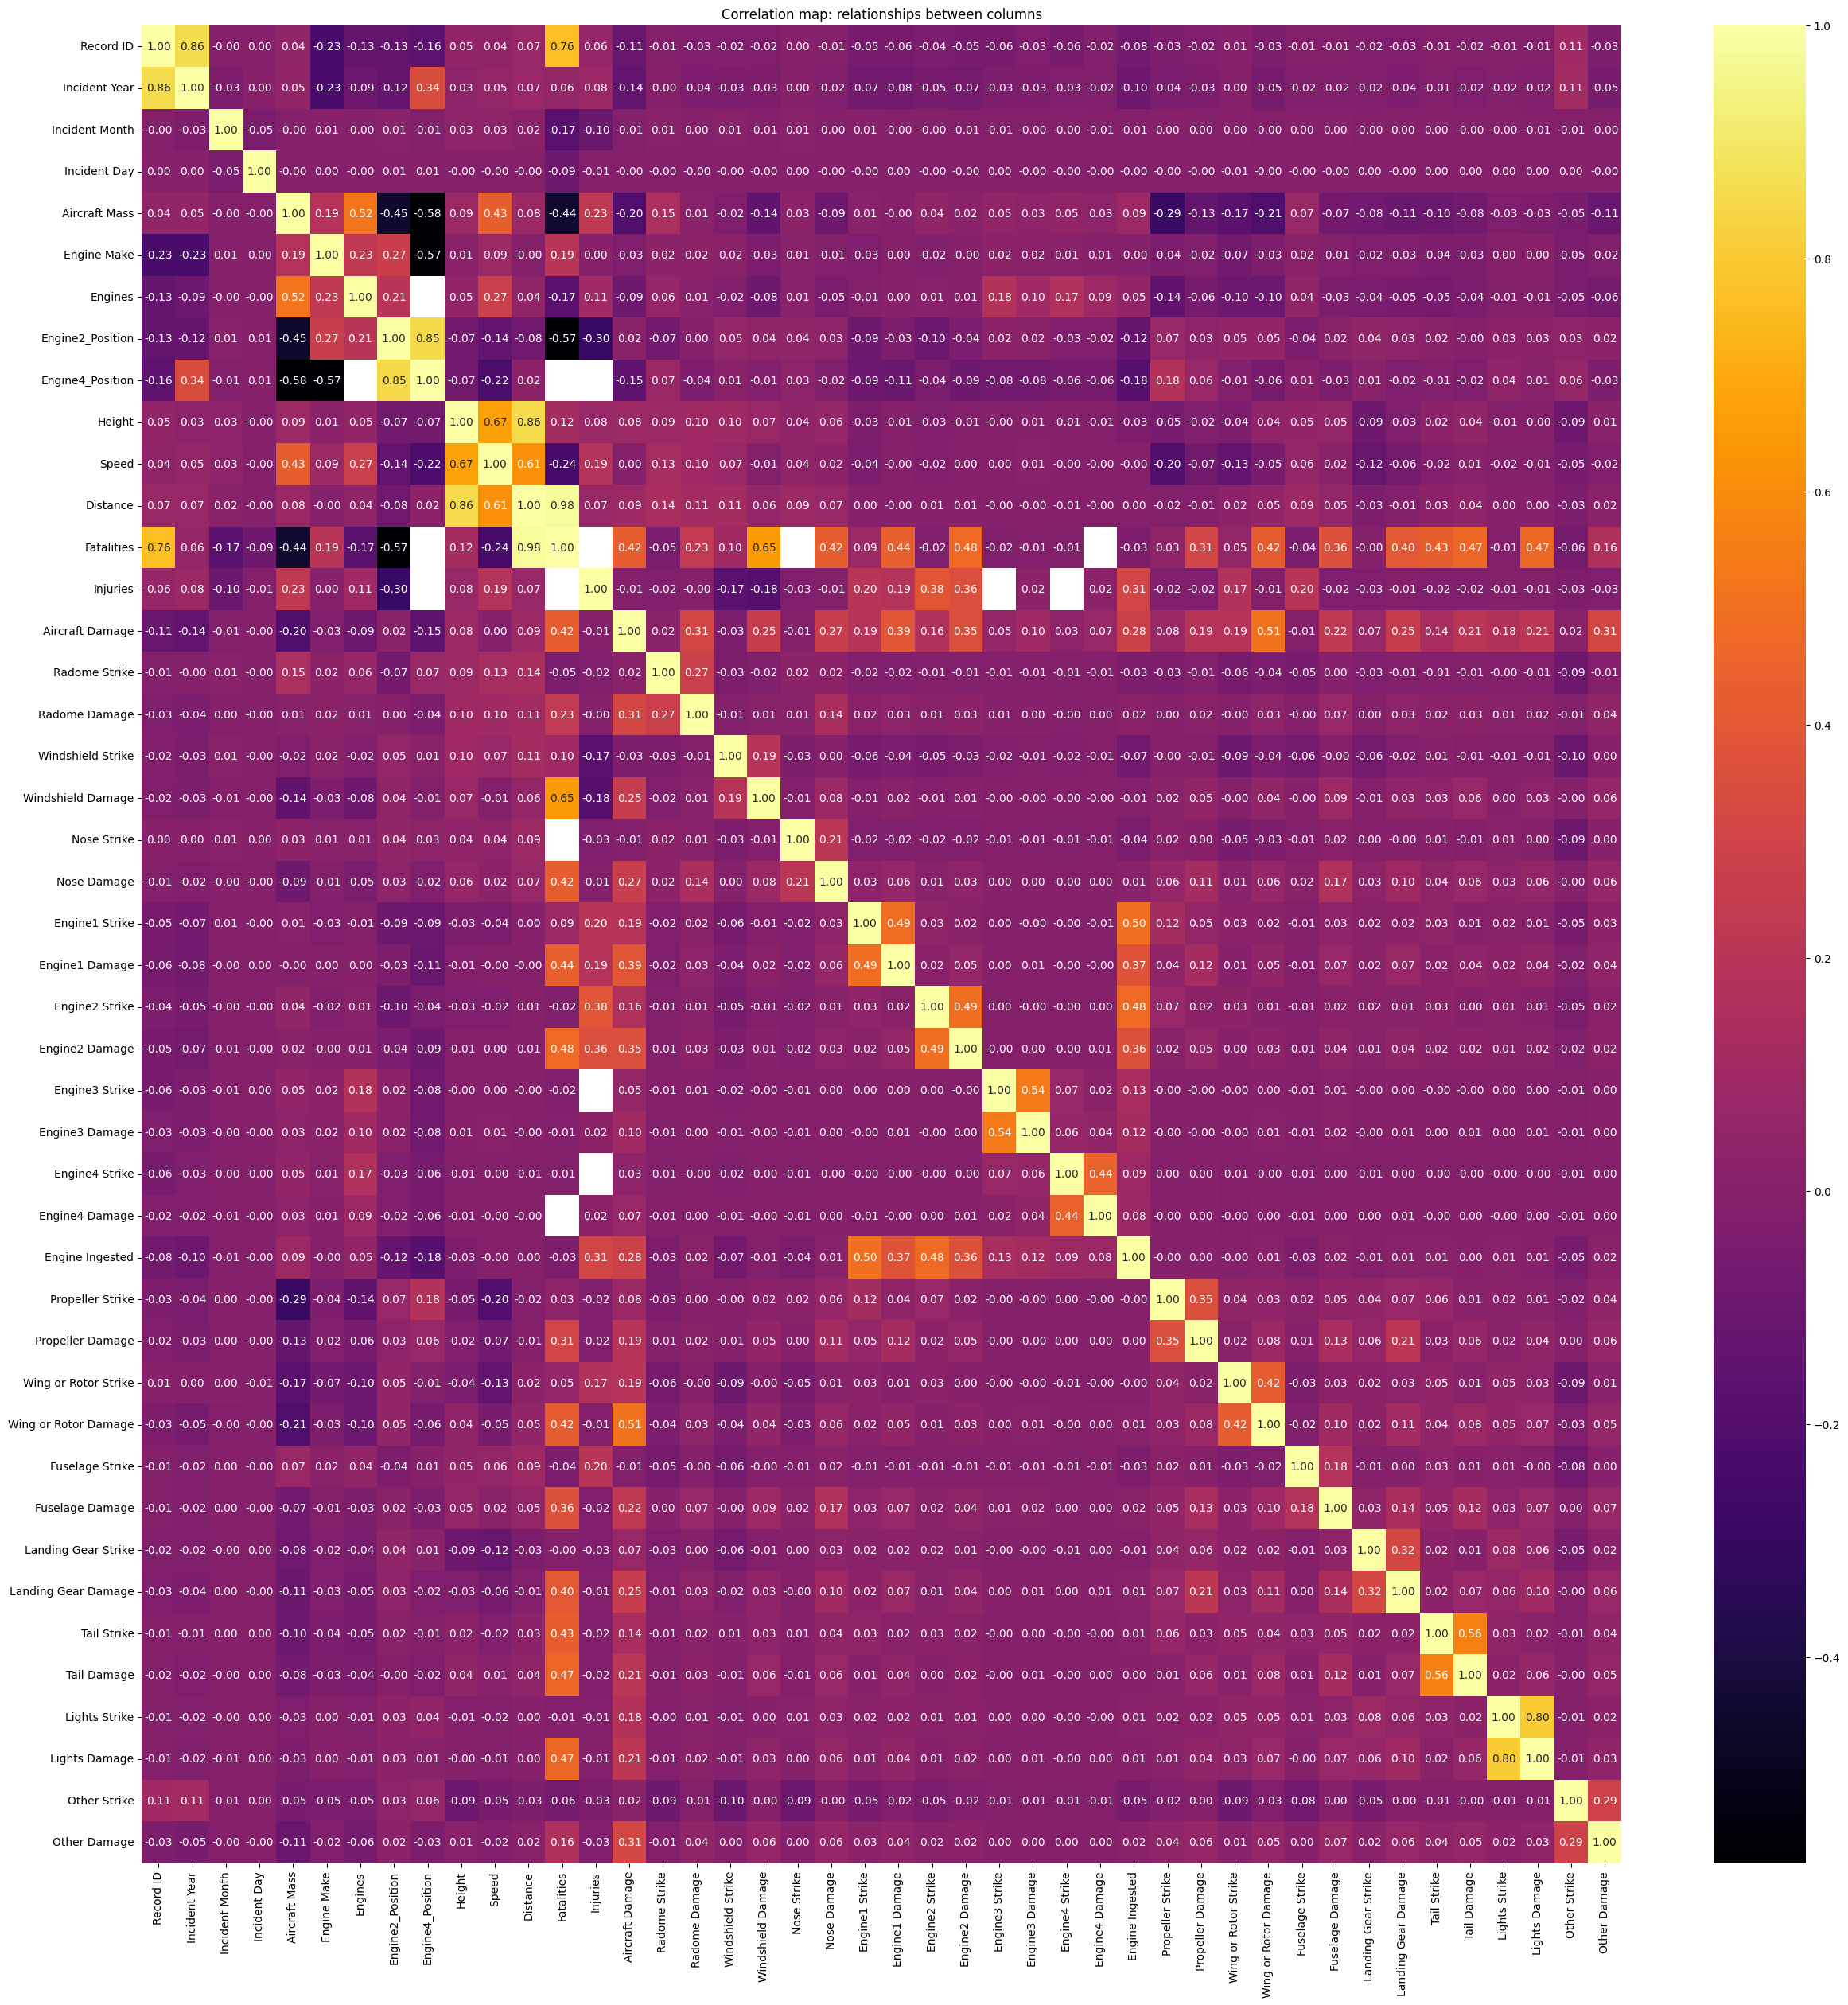

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(data.corr(), cmap = "inferno", annot=True, fmt=".2f")
plt.title ("Correlation map: relationships between columns")
plt.show()

In [ ]:
target_cols = ['Engine1_Position', 'Engine2_Position', 'Engine3_Position', 'Engine4_Position']
data[target_cols] = data[target_cols].apply(pd.to_numeric) #CHange any stray strings to numeric values

In [ ]:
data.drop(columns = ["Airport", "Operator", "Record ID", "Species Name"], inplace=True)

In [ ]:
dummy_cols = ['Incident Year', 'Incident Month', 'Incident Day', 'Operator ID',
              'Aircraft', 'Aircraft Type', 'Aircraft Make', 'Aircraft Model', 'Engine Make', 'Engine Model',
              'Engine Type', 'Engine1_Position', 'Engine2_Position',
              'Engine3_Position', 'Engine4_Position', 'Airport ID', 'State',
              'FAA Region', 'Warning Issued', 'Flight Phase', 'Visibility',
              'Precipitation', 'Species ID', "Species Quantity"]

In [ ]:
data.replace({"ENGINE SHUT DOWN" : "ENGINE SHUTDOWN"}, inplace=True)

In [ ]:
data = pd.get_dummies(data, columns = dummy_cols)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174039 entries, 0 to 174103
Columns: 4731 entries, Aircraft Mass to Species Quantity_Over 100
dtypes: float64(7), int64(30), object(1), uint8(4693)
memory usage: 830.7+ MB


In [ ]:
data["Fatalities"].fillna(0, inplace=True)
data["Injuries"].fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174039 entries, 0 to 174103
Columns: 4731 entries, Aircraft Mass to Species Quantity_Over 100
dtypes: float64(7), int64(30), object(1), uint8(4693)
memory usage: 830.7+ MB


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.reset_index(inplace=True)

In [ ]:
#y_columns = ["Flight Impact_NONE", "Flight Impact_PRECAUTIONARY LANDING",
 #            "Flight Impact_OTHER", "Flight Impact_ABORTED TAKEOFF", "Flight Impact_ENGINE SHUTDOWN"] #"Fatalities", "Injuries",
y_columns = ["Flight Impact"]
X_columns = data.columns.tolist()
for column in y_columns:
  X_columns.remove(column)

In [ ]:
print(data.head())

   index  Aircraft Mass  Engines  Height  Speed  Distance  \
0     12            3.0      2.0     0.0  100.0       0.0   
1     14            4.0      2.0     0.0  140.0       0.0   
2    128            4.0      3.0     0.0  120.0       0.0   
3    131            2.0      2.0     0.0  100.0       0.0   
4    132            2.0      2.0     0.0   80.0       0.0   

           Flight Impact  Fatalities  Injuries  Aircraft Damage  ...  \
0  PRECAUTIONARY LANDING         0.0       0.0                1  ...   
1  PRECAUTIONARY LANDING         0.0       0.0                1  ...   
2                   NONE         0.0       0.0                0  ...   
3        ABORTED TAKEOFF         0.0       0.0                0  ...   
4                   NONE         0.0       0.0                0  ...   

   Species ID_ZY1  Species ID_ZY101  Species ID_ZY102  Species ID_ZY103  \
0               0                 0                 0                 0   
1               0                 0               

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data[y_columns], train_size=0.7)

In [ ]:
resampler = SMOTETomek() #Will generate default options for both SMOTE and TomekLinks
X_train, y_train = resampler.fit_resample(X_train, y_train)


In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
print(tree_model.score(X_test, y_test))
print(tree_model.predict(X_test))
print(y_test)

0.8626916524701874
['NONE' 'NONE' 'NONE' ... 'NONE' 'NONE' 'NONE']
      Flight Impact
15629          NONE
27323          NONE
2808           NONE
8694           NONE
14092          NONE
...             ...
21086          NONE
7237           NONE
22791          NONE
11426          NONE
20411          NONE

[8805 rows x 1 columns]


<Figure size 640x480 with 0 Axes>

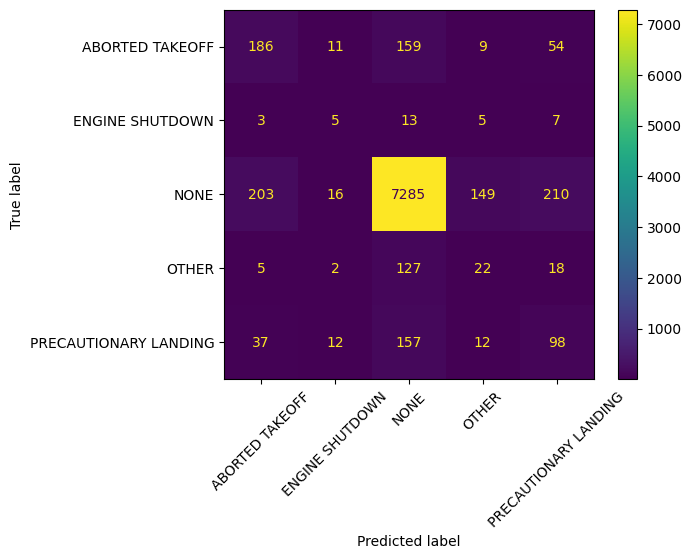

In [ ]:
plt.figure()
ConfusionMatrixDisplay.from_estimator(tree_model, X_test, y_test) #cmap="inferno"
plt.xticks(rotation=45)

plt.show()

In [ ]:
#plt.figure()
#plot_tree(tree_model, filled=True)
#plt.show()

In [ ]:
forest_model = RandomForestClassifier(n_estimators=100)
forest_model.fit(X_train, y_train)
print(forest_model.predict(X_test))
print(forest_model.score(X_test, y_test))

<ipython-input-25-034b45f8c267>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_model.fit(X_train, y_train)


['NONE' 'NONE' 'NONE' ... 'NONE' 'NONE' 'NONE']
0.9021010789324247


<Figure size 640x480 with 0 Axes>

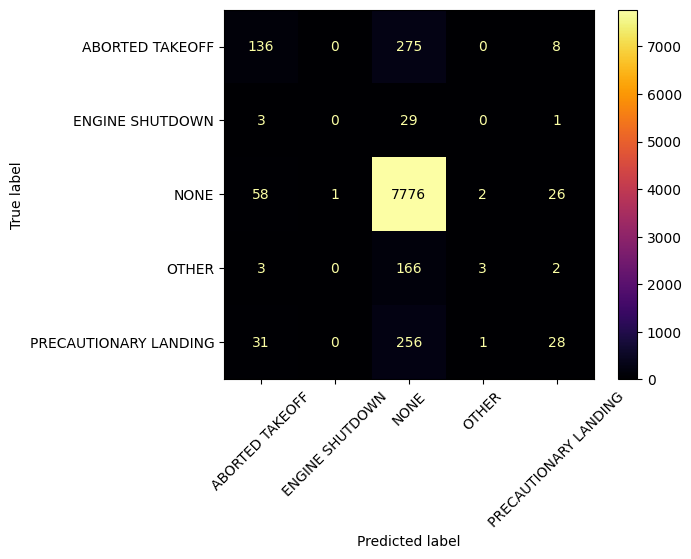

In [ ]:
plt.figure()
ConfusionMatrixDisplay.from_estimator(forest_model, X_test, y_test, cmap="inferno")
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(forest_model.predict(X_test))

['NONE' 'NONE' 'NONE' ... 'NONE' 'NONE' 'NONE']


In [ ]:
prediction=forest_model.predict_proba(X_test)[:,1]
print(np.shape(prediction))

(8805,)


In [ ]:
#fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=prediction)

In [ ]:
#print(np.unique(thresholds))

In [ ]:
#plt.figure()
#plt.plot(tpr, tpr, label = "No Skill")
#plt.plot(fpr, tpr, label = "Algorithm")
#plt.xlabel("False Positive Rate")
##plt.ylabel("True Positive Right")
#plt.legend()
#plt.show()

In [ ]:
# def round_threshold(predictions, threshold=0.5):
#   values = predictions - threshold
#   values = abs(np.ceil(values)).astype(int)
#   return values

In [ ]:
# new_predictions = round_threshold(predictions=prediction, threshold=0.7)

In [ ]:
# print(new_predictions)

In [ ]:
# plt.figure()
# plt.plot(thresholds, tpr, label = "tpr")
# plt.plot(thresholds, fpr, label = "fpr")
# plt.xlabel("Treshold Value")
# plt.ylabel("Rate")
# plt.title ("Rates Vs. Tresholds")
# plt.legend()
# plt.show

In [ ]:
y_train_dummies = pd.get_dummies(y_train)
y_test_dummies = pd.get_dummies (y_test)

In [ ]:
print(y_train.columns)
print(y_test.columns)

Index(['Flight Impact'], dtype='object')
Index(['Flight Impact'], dtype='object')


In [ ]:
dnn_model = Sequential()

dnn_model.add(Input(len(X_columns)))

dnn_model.add(Dense(1200, activation = "relu"))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(800, activation = "relu"))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(500, activation = "relu"))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(100, activation = "relu"))
dnn_model.add(Dropout(0.5))

dnn_model.add(Dense(20, activation = "relu"))
dnn_model.add(Dropout(0.5))


dnn_model.add(Dense(len(y_test_dummies.columns), activation = "softmax")) #softmax is sigmoid for multiple classes. sigmoid for classifiers, relu for refressors

In [ ]:
dnn_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
dnn_loss = "CategoricalCrossentropy"

early_stopping = EarlyStopping(monitor= "val_loss", patience=10, restore_best_weights=True)
plateau_monitor = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=15, restore_best_weights=True)

In [ ]:
dnn_model.compile(dnn_optimizer, dnn_loss)
dnn_model.fit(X_train, y_train_dummies, batch_size=3000, epochs=100, verbose=1, validation_split=0.2, callbacks=[early_stopping, plateau_monitor])

Epoch 1/100
25/25 [==============================] - 65s 3s/step - loss: 534.6879 - val_loss: 2.1933 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 71s 3s/step - loss: 13.5568 - val_loss: 1.6648 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 54s 2s/step - loss: 2.4748 - val_loss: 1.6964 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 59s 2s/step - loss: 1.8155 - val_loss: 1.7809 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 56s 2s/step - loss: 1.7117 - val_loss: 1.8669 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 62s 2s/step - loss: 1.6428 - val_loss: 1.9545 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 59s 2s/step - loss: 1.6099 - val_loss: 2.0379 - lr: 0.0010
Epoch 8/100
25/25 [==============================] - 60s 2s/step - loss: 1.5783 - val_loss: 2.1160 - lr: 0.0010
Epoch 9/100
25/25 [==============================] - 54s 2s/step - loss: 1.5732 - val_loss: 2.1978 - 

In [ ]:
dnn_prediction = np.zeros((len(y_test_dummies)))
dnn_test_coded = np.zeros((len(y_test_dummies)))

# y_test_dummies is 5 columns
dnn_result = dnn_model.predict(X_test) # Five colums

for i in range(len(y_test_dummies)):
  dnn_test_coded[i] = np.argmax(y_test_dummies.iloc[i])
  dnn_prediction[i] = np.argmax(dnn_result[i])

print(dnn_prediction)

276/276 [==============================] - 5s 17ms/step
[1. 1. 1. ... 1. 1. 1.]


<Figure size 640x480 with 0 Axes>

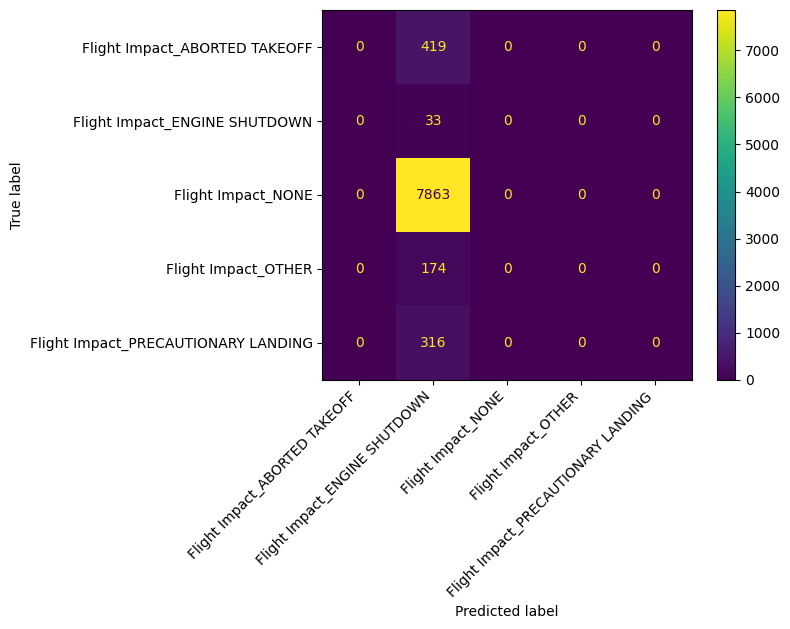

In [ ]:
plt.figure()
ConfusionMatrixDisplay.from_predictions(dnn_test_coded, dnn_prediction, display_labels=y_test_dummies.columns.tolist())
plt.xticks(rotation = 45, ha="right")
plt.show()